In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.path.abspath(''), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import lib.data

In [2]:
import sys
sys.path.append("../../")

import math

from lib.data.dataplot import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.system.controllers import *
from lib.system.trajectory import *

class Multirotor:

    def __init__(self):
        self.vz_control = PID_Controller(5.0, 10.0, 0.0, 5)
        self.z_control = PID_Controller(2.0, 0.0, 0.0, 2)  # 2 m/s
        
        self.w_roll_control = PID_Controller(0.75, 0.3, 0.0075, 2)
        self.roll_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s

        self.w_pitch_control = PID_Controller(0.75, 0.3, 0.0075, 2)
        self.pitch_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s
        
        self.vy_control = PID_Controller(0.4, 0.015, 0.25, math.radians(30))
        self.y_control = PID_Controller(1.0, 0.0, 0.0, 4.0)

        self.vx_control = PID_Controller(0.4, 0.015, 0.25, math.radians(30))
        self.x_control = PID_Controller(2.0, 0.0, 0.0, 4.0)
        
        self.z_target = 0.0
        self.x_target = 0.0
        self.y_target = 0.0

    def evaluate(self, delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate):
        self.x = x
        self.y = y
        self.z = z
        # propeller order
        #
        #  3     4
        #
        #  2     1
        #
        
        # altitude control
        self.vz_target = self.z_control.evaluate(delta_t, self.z_target - z)
        f = self.vz_control.evaluate(delta_t, self.vz_target - vz)
        
        self.vy_target = self.y_control.evaluate(delta_t, self.y_target - y)
        self.roll_target = - self.vy_control.evaluate(delta_t, self.vy_target - vy)
        
        self.vx_target = self.x_control.evaluate(delta_t, self.x_target - x)
        self.pitch_target = self.vx_control.evaluate(delta_t, self.vx_target - vx)
        
        # roll control
        self.roll_rate_target = self.roll_control.evaluate(delta_t, self.roll_target - roll)
        roll_command = self.w_roll_control.evaluate(delta_t, self.roll_rate_target - roll_rate)
        
        # pitch control
        self.pitch_rate_target = self.pitch_control.evaluate(delta_t, self.pitch_target - pitch)
        pitch_command = self.w_pitch_control.evaluate(delta_t, self.pitch_rate_target - pitch_rate)
        
        
        return f + roll_command - pitch_command, f - roll_command - pitch_command, \
                f - roll_command + pitch_command, f + roll_command + pitch_command


class AbstractMovement:
    
    def __init__(self, _robot):
        self.robot = _robot
        
    def start(self):
        pass
        
    def evaluate(self, delta_t):
        pass
    
    def movement_done(self):
        return False


class ZMovement(AbstractMovement):
    
    def __init__(self, _robot, _z_target):
        super().__init__(_robot)
        self.z_target = _z_target
        
    def evaluate(self, delta_t):
        self.robot.z_target = self.z_target
        
    def movement_done(self):
        return abs(self.robot.z - self.z_target) < 0.01
     
        
class XYMovement(AbstractMovement):
    
    def __init__(self, _robot, _x_target, _y_target):
        super().__init__(_robot)
        self.x_target = _x_target
        self.y_target = _y_target
        self.virtual_drone = StraightLine2DMotion(2.0, 4.0, 4.0)
        
    def start(self):
        self.virtual_drone.start_motion( (self.robot.x, self.robot.y),
                                         (self.x_target, self.y_target))
        
    def evaluate(self, delta_t):
        (x_t, y_t) = self.virtual_drone.evaluate(delta_t)
        self.robot.x_target = x_t
        self.robot.y_target = y_t
        
    def movement_done(self):
        dx = self.x_target - self.robot.x
        dy = self.y_target - self.robot.y
        dist = math.sqrt(dx*dx + dy*dy)
        return dist < 0.01
     

class Circle(AbstractMovement):
    
    def __init__(self, _robot, _radius):
        super().__init__(_robot)
        self.radius = _radius
        self.virtual_drone = VirtualRobot(2 * math.pi *_radius, 0.5, 4.0, 4.0)
        
    def start(self):
        self.center_x = self.robot.x
        self.center_y = self.robot.y
        
    def evaluate(self, delta_t):
        self.virtual_drone.evaluate(delta_t)
        arc = self.virtual_drone.position()
        angle = arc / self.radius
        x_t = self.radius * math.cos(angle)
        y_t = self.radius * math.sin(angle)
        self.robot.x_target = x_t
        self.robot.y_target = y_t
        
    def movement_done(self):
        return self.virtual_drone.phase == VirtualRobot.TARGET
    



In [3]:
packet_one_pos = [-0.976, 0.087]

FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO
AAAAAAAAAAAAAAA


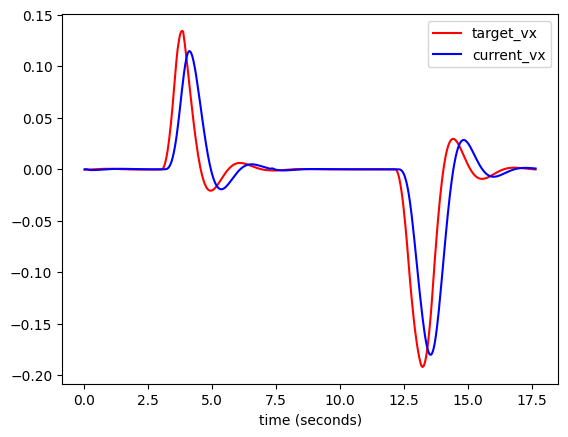

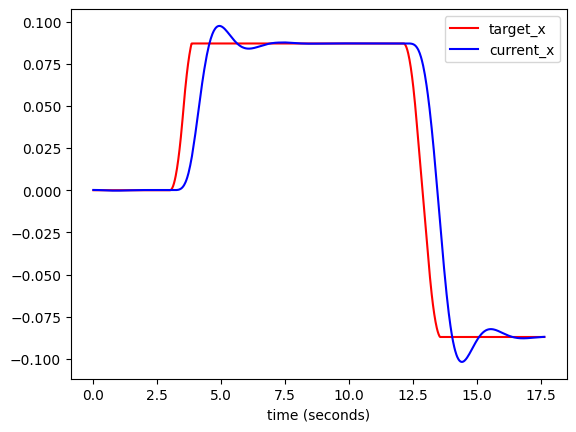

Done


In [4]:
dpvz = DataPlotter()
dpvz.set_x("time (seconds)")
dpvz.add_y("target_vx", "target_vx")
dpvz.add_y("current_vx", "current_vx")

dpz = DataPlotter()
dpz.set_x("time (seconds)")
dpz.add_y("target_x", "target_x")
dpz.add_y("current_x", "current_x")

dds = DDS()
dds.start()

dds.subscribe(['start','tick', 'X', 'Y', 'Z', 'TX', 'TY', 'TZ', 'VX', 'VY', 'VZ', 'WX', 'WY', 'WZ'])

robot = Multirotor()

move_list = [ ZMovement(robot, 1.0), 
              XYMovement(robot, packet_one_pos[1], packet_one_pos[0]),
              ZMovement(robot, 0.5),
              ZMovement(robot, 2.0),
              XYMovement(robot, -packet_one_pos[1], -packet_one_pos[0]),]

move_command = move_list.pop(0)
move_command.start()

t = Time()
t.start()

while True:
    
    dds.wait('tick')    
    delta_t = t.elapsed()
    
    z = dds.read('Z')
    vz = dds.read('VZ')
    
    x = dds.read('X')
    vx = dds.read('VX')
    
    y = dds.read('Y')
    vy = dds.read('VY')
    
    roll = dds.read('TX')
    roll_rate = dds.read('WX')
    
    pitch = dds.read('TY')
    pitch_rate = dds.read('WY')
    
    (f1, f2, f3, f4) = robot.evaluate(delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate)

    move_command.evaluate(delta_t)
    
    if move_command.movement_done():
        print("FINITO MOVIMENTO")
        
        if move_list == []:
            print("FINITO")
            break
            
        move_command = move_list.pop(0)
        move_command.start()

    dds.publish('f1', f1, DDS.DDS_TYPE_FLOAT)
    dds.publish('f2', f2, DDS.DDS_TYPE_FLOAT)
    dds.publish('f3', f3, DDS.DDS_TYPE_FLOAT)
    dds.publish('f4', f4, DDS.DDS_TYPE_FLOAT)
    
    dpvz.append_x(t.get())
    dpvz.append_y("target_vx", robot.vx_target)
    dpvz.append_y("current_vx", vx)

    dpz.append_x(t.get())
    dpz.append_y("target_x", robot.x_target)
    dpz.append_y("current_x", x)


print("AAAAAAAAAAAAAAA")
dds.publish('f1', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f2', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f3', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f4', 0, DDS.DDS_TYPE_FLOAT)

dds.stop()
dpvz.plot()
dpz.plot()

print("Done")

In [5]:
print("a")

a
